# TODO

- Deterministic
    - Will probably want to use generators when paralleizing


- Specular reflection
    
    
- Optimization
    - Make the code faster...
    - What data to store
        - Need to store cound electrons reaching contacts!!!
    
    
- Ohmstats and colormap plotting
    - Ohmstats line
    - Ease, speed, and correctness

# Init

In [1]:
%%capture

%load_ext line_profiler

import importlib
from cycler import cycler
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

import monte_carlo_simulation as mcs
importlib.reload(mcs)
from shapely.geometry import LineString
from shapely.geometry import Point

import cProfile

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

# Simulation

## Bar

In [2]:
k = delafossite()
bar_frame = caustic_frame.Frame('geo/bar.dxf')
bar_sim = mcs.Simulation(bar_frame, k, 0, 15, 10)
bar_sim.set_seed(0)

In [3]:
bar_sim.get_intersections([(0,0),(1,0)])

/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:238: RuntimeWarning: divide by zero encountered in true_divide
  (x01*self.frame.y23 - y01*self.frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:239: RuntimeWarning: divide by zero encountered in true_divide
  us = -(x01*y02 - y01*x02) / (x01*self.frame.y23 - y01*self.frame.x23)


[(((0.5, 4.9), (0.5, -4.9), 0), 0.4999999999, 0.0)]

In [4]:
len(bar_frame.edges)

8

In [5]:
np.shape(bar_frame.x23)

(8,)

In [6]:
8*np.ones(8)  - 8*np.ones(8)

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
xs = np.array([edge.xs[0] for edge in bar_frame.edges])
xs

array([-0.5,  0.5,  0.5,  0.5,  0.5, -0.5, -0.5, -0.5])

In [8]:
num_edges = len(bar_sim.frame.edges)
x = 0
y = 0
x_new = 0.5
y_new = 3

x01 = x - x_new
y01 = y - y_new
x02 = x - bar_sim.frame.px0
y02 = y - bar_sim.frame.py0
x_del = x_new - x
y_del = y_new - y

ts = (x02*bar_frame.y23 - y02*bar_frame.x23) / (x01*bar_frame.y23 - y01*bar_frame.x23)
us = -(x01*y02 - y01*x02) / (x01*bar_frame.y23 - y01*bar_frame.x23)

intersections = []
for i, (t, u) in enumerate(zip(ts, us)):
    if 0 <= t and t <= 1 and 0 <= u and u <= 1:
        print(u, t)
        edge = bar_frame.edges[i]
        if x_del * edge.normal[0] + y_del * edge.normal[1] < 0:
            x_int = edge.xs[0] + u*(edge.xs[1] - edge.xs[0])
            y_int = edge.ys[0] + u*(edge.ys[1] - edge.ys[0])
            
            x_t = x + t*(x_new - x)
            y_t = y + t*(y_new- y)
            if x_int != x or y_int != y:
                bias_vector = 1E-10 * \
                    np.array([(x_new-x), (y_new-y)]) / \
                    np.sqrt((x_new-x)**2 + (y_new-y)**2)
                intersections.append(
                    (edge, x_int - bias_vector[0], y_int - bias_vector[1]))
    
print(x_int, y_int)
print(x_t, y_t)

0.19387755102040818 1.0
0.5 3.0
0.5 3.0


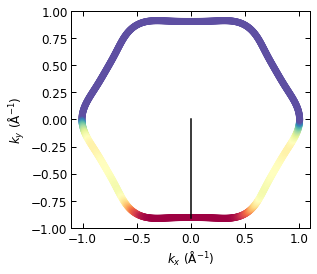

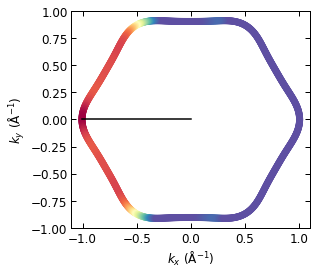

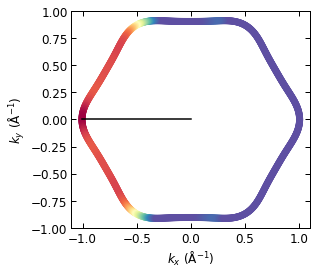

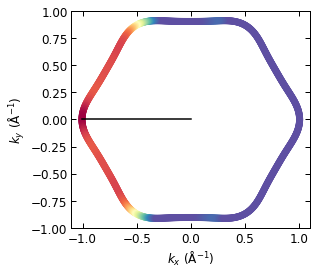

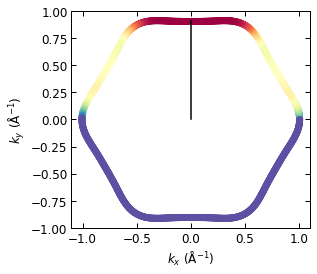

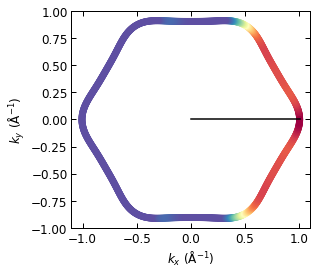

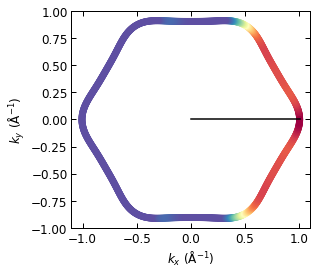

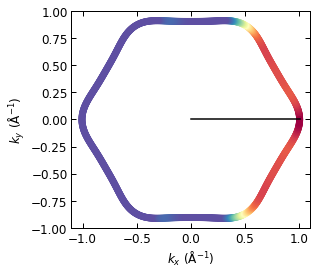

In [12]:
cmap = plt.get_cmap('Spectral_r')

for edge in bar_sim.frame.edges:
    max_p = np.max(edge.in_prob)
    colors = np.array([cmap(p/max_p) for p in edge.in_prob])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig, ax = plt.subplots()
    plt.plot((0, (np.max(bar_sim.bandstructure.k[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), (0, (np.max(bar_sim.bandstructure.k[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
    plt.scatter(bar_sim.bandstructure.k[0], bar_sim.bandstructure.k[1],c=colors)
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    ax.set_aspect('equal')

In [13]:
bar_sim.frame.edges[1]

((0.5, 5.0), (0.5, 4.9), 2)

In [14]:
#%lprun -f bar_sim.get_sorted_intersections -f bar_sim.get_intersections -f bar_sim.step_position bar_sim.run_simulation(debug=False)

In [15]:
cProfile.runctx("bar_sim.run_simulation(debug=False)", globals(), locals(), sort='cumtime')

         966174 function calls in 3.420 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.420    3.420 {built-in method builtins.exec}
        1    0.012    0.012    3.420    3.420 <string>:1(<module>)
        1    0.147    0.147    3.408    3.408 monte_carlo_simulation.py:34(run_simulation)
    80205    0.343    0.000    3.205    0.000 monte_carlo_simulation.py:59(step_position)
    80205    0.281    0.000    1.707    0.000 monte_carlo_simulation.py:198(get_sorted_intersections)
    80205    1.371    0.000    1.372    0.000 monte_carlo_simulation.py:218(get_intersections)
    80205    0.611    0.000    1.043    0.000 monte_carlo_simulation.py:182(update_position)
    80205    0.184    0.000    0.432    0.000 <__array_function__ internals>:2(shape)
    80461    0.121    0.000    0.194    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   160578    0.105    0.000

In [16]:
bar_trajectories = bar_sim.run_simulation(debug=True)

In [17]:
bar_sim.frame.edges[0].num_collisions

19

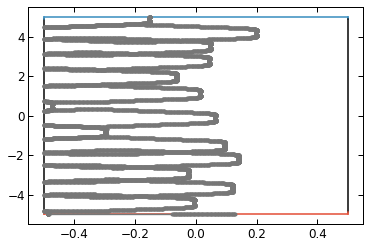

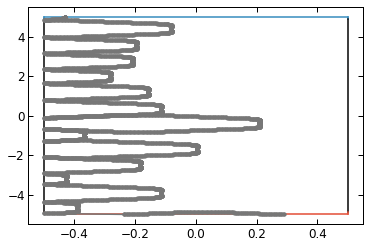

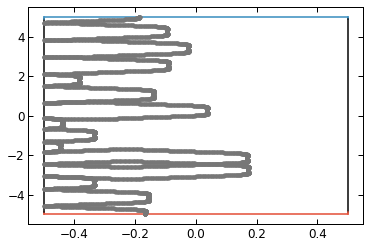

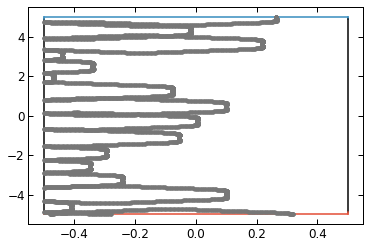

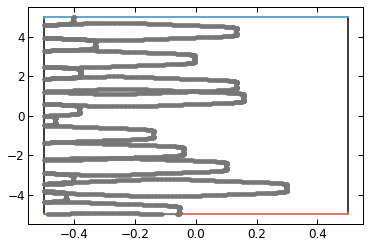

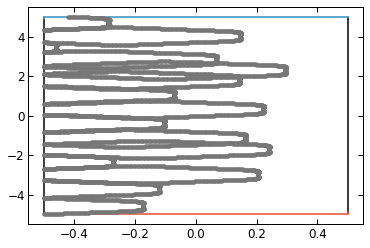

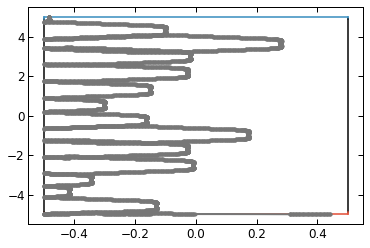

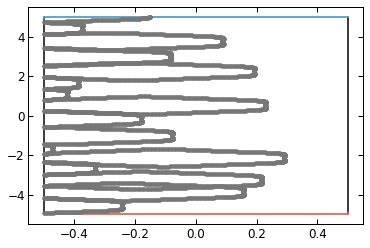

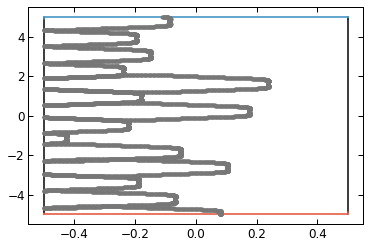

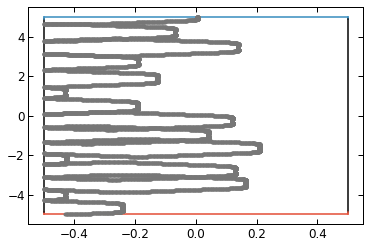

In [18]:

for trajectory in bar_trajectories:
    fig = bar_frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3.-')
    #plt.axes().set_aspect('equal')
    #plt.ylim(-5.1,-4)

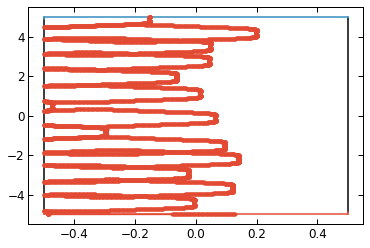

In [19]:
fig = bar_frame.gen_fig()
ns, xs, ys = zip(*bar_trajectories[0])
plt.plot(xs,ys, '.-')
#plt.ylim(-5.1,-4)

## TEF

In [20]:
k = delafossite()
frame = caustic_frame.Frame('geo/tef.dxf')
sim = mcs.Simulation(frame, k, 0, -15, 10)
sim.set_seed(1)

In [21]:
%lprun -f sim.run_simulation -f sim.get_sorted_intersections -f sim.get_intersections -f sim.step_position sim.run_simulation(debug=False)

In [27]:
t0 = time.time()
trajectories = sim.run_simulation(debug=False)
t1 = time.time()
print(t1-t0)

16.801108360290527


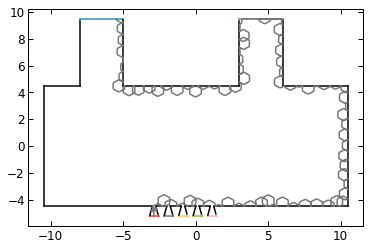

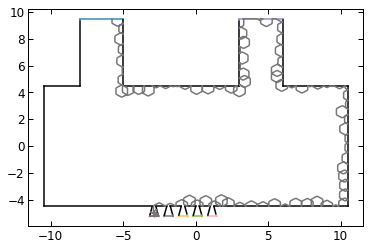

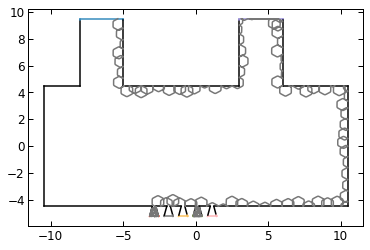

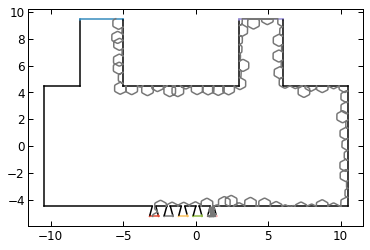

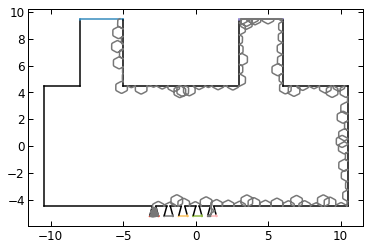

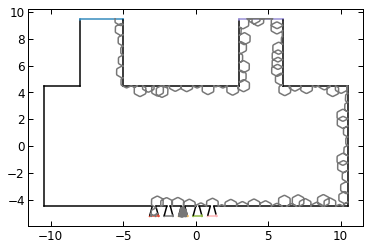

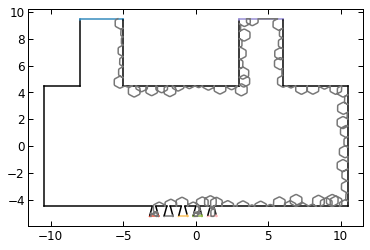

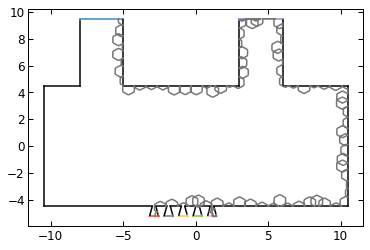

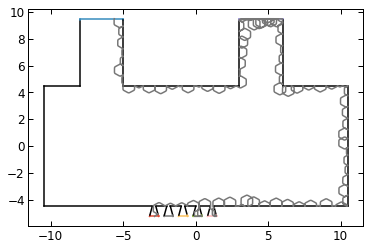

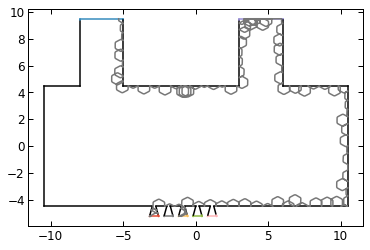

In [23]:
for trajectory in trajectories:
    fig = frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3')
    #plt.xlim(-3.5, 1.75)
    #plt.ylim(-5.3, -4)

In [26]:
trajectories[1][-1]
ns, xs, ys = zip(*trajectories[1])

print(ns[-5:])
print(xs[-5:])
print(ys[-5:])

ind = -2
print('')
print('inputs')
print(ns[ind], xs[ind], ys[ind])
n_up, x_up, y_up = sim.update_position(ns[ind], xs[ind], ys[ind])
print('update position')
print(n_up, x_up, y_up)


line_step = LineString([(xs[ind], ys[ind]), (x_up, y_up)])
intersections = sim.get_sorted_intersections(line_step)

vec = np.array([(x_up-xs[ind]), (y_up-ys[ind])])/np.sqrt((x_up-xs[ind])**2 +(y_up-ys[ind])**2)
print('')
print('intersection stuff')
print(intersections)
print(intersections[0])
edge, x_new, y_new, _ = intersections[0]
print(edge.layer, x_new, y_new)


print('')
print('shapely checks')
print(sim.frame.body.intersects(Point(xs[ind], ys[ind])))
print(sim.frame.body.intersects(Point(x_up, y_up)))
print(sim.frame.body.intersects(Point(x_new, y_new)))
print(sim.frame.body.intersects(Point([x_new, y_new]-1E-15*vec)))

fig = frame.gen_fig()
plt.plot(xs[-10:],ys[-10:],'.-')
plt.plot([xs[ind], x_up], [ys[ind], y_up],'.-k')
plt.xlim(-1, 1)
plt.ylim(-5.3, -4.4)


fig = frame.gen_fig()
plt.plot(xs[-3:],ys[-3:], '.-')
plt.plot(xs[-3],ys[-3], 'g.', markersize=12)
plt.plot(xs[-2],ys[-2], 'b.', markersize=12)
plt.plot(xs[-2]-1E-10*vec[0],ys[-2]-1E-10*vec[1], 'r.', markersize=12)
plt.plot([xs[ind], x_new], [ys[ind], y_new],'.-k')
plt.xlim(-1, 1)
plt.ylim(-5.3, -4.4)


print('')
print('step_position')
sim.step_position(ns[ind], xs[ind], ys[ind])

((788, 1), (789, 1), (790, 1), (791, 1), (792, 1))
(-5.777664469257366, -5.777790216216202, -5.777911773319993, -5.778027957513025, -5.778079348834959)
(9.490681100814964, 9.493367188636594, 9.496053468968316, 9.498739986518942, 9.499999999900083)

inputs
(791, 1) -5.778027957513025 9.498739986518942
update position
(792, 1) -5.778137541985285 9.501426780635502


TypeError: 'LineString' object does not support indexing

In [ ]:
n_f = (173, 0.25031344146242784)
x = -2.749411058924586
y = -5.25
dr = np.array([1.46095278, 3.75949037])
[x,y] + n_f[1]*dr

In [ ]:
sim.step_position((276,1), 0.5, -5)


In [ ]:
line_step = LineString([(0.5, -5), (0.5001522540877086, -4.995969331642936)])
sim.get_intersections(line_step)

In [ ]:
x = 0.49
y = -4.9

line_step = LineString([(0.49, -4.9),(0.49, -5)])
intersections = sim.get_sorted_intersections(line_step)
list(intersections)

In [ ]:
line_step = LineString([(0.51, -4.),(0.49, -5.1)])
intersections = sim.get_sorted_intersections(line_step)
intersections

In [ ]:
freq = np.zeros(999)
n = 1000
for i in range(n):
    line_step = LineString([(0.49, -4.9),(0.5, -5)])
    intersections = sim.get_sorted_intersections(line_step)
    edge_0, x_new, y_new, _ = intersections[0]
    edge_1, _, _, _ = intersections[1]
    n_new, f_new = sim.corner_scatter(edge_0, edge_1)
    freq[n_new] += 1
    if edge_0.in_prob[n_new] <= 0 or edge_1.in_prob[n_new] <= 0:
        print(n_new)
    
prob = freq/n
fig = plt.figure()
plt.plot(edge_0.cum_prob)
plt.plot(edge_1.cum_prob)
plt.plot(np.cumsum(prob))

fig = plt.figure()
plt.plot(edge_0.in_prob)
plt.plot(edge_1.in_prob)
plt.plot(prob)

# Corner handling




- Propagating into a corner
    - exterior corner vs interior corner
        - Exterior corner:
            - What are the edge layers?
            - If scattering, take some convolved pld
        - Interior corner
            - Probably some convolution again
    - current code will return both edges being hit
    
    
    
- Convolving plds:
    - cumsum(pld_1 * pld_2)/sum(pld_1 * pld_2)?

- Injecting from corner
    - Could reject corner injection
        - This should be fine to do
        - np.random.rand chooses in [0,1)
    - Know this is an injection event and check collision with the corner
        - Requires rewriting get_intersection
    - When injecting, know you are injecting from the corner
        - Separate function corner check?
        - Choose stated from convolved probability dists

In [ ]:
r = np.random.rand()

cum_prob = sim.frame.edges[0].cum_prob

n = np.argmax(sim.frame.edges[0].cum_prob > r)
print(n, r, cum_prob[n-1], cum_prob[n])

In [ ]:
remainder = (r-cum_prob[n-1])/(cum_prob[n] - cum_prob[n-1])
print(n-1+remainder)
print(cum_prob[n] - cum_prob[n-1])
print(r - cum_prob[n-1])
ind = n-1+remainder

In [ ]:
cum_prob[-2]

In [ ]:
from geo.caustic_frame import Edge
Edge.compute_injection_index(cum_prob)

In [ ]:
np.shape(cum_prob)

In [ ]:
np.floor(ind)

In [ ]:
(1- (ind - np.floor(ind)))* sim.bandstructure.dr[:, int(np.floor(ind))]

In [ ]:
999.5 % 999

In [ ]:
x = [1, 2 ,3, 5]
cumsum = np.cumsum(x)
cumsum

In [ ]:
np.argmax(cumsum < 0.5)

Before:
n = np.argmax(cum_sum > rand)
Returns first index of cum_sum that is bigger than rand

Step was then dr[:, n]

Now want to return fractional index that corresponds to r (which is in range of (n-1, n))

this maps to (ceil(n)-n) * dr[:, ceil(n)]?
Needs correct modulo


(n, f) = 